# Load and Preprocess

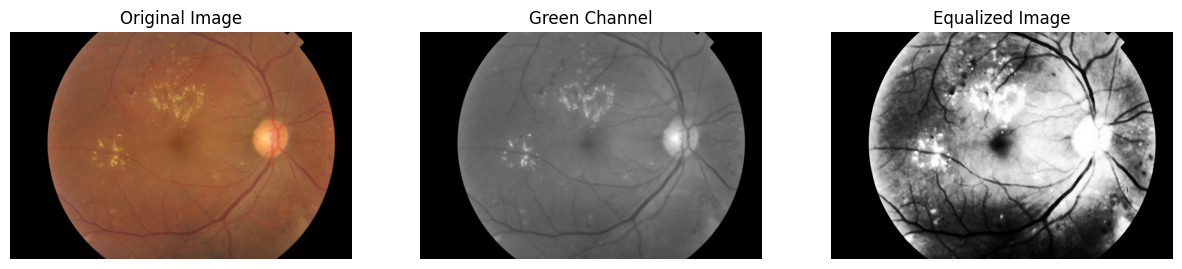

In [25]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from skimage.morphology import skeletonize, label
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the fundus image
    image = cv2.imread(image_path)
    
    # Convert to grayscale to detect the fundus boundary
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## REPLACE BLACK BACKGROUND CODE
    # Threshold the grayscale image to create a binary mask
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    # Find the contours of the fundus region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the largest contour (assumed to be the fundus) on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    # Apply the mask to remove the background in the original image
    image_with_black_bg = cv2.bitwise_and(image, image, mask=mask)

    # Apply denoising to reduce noise in the image
    denoised_image = cv2.fastNlMeansDenoisingColored(image_with_black_bg, None, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # Extract the green channel from the denoised image
    green_channel = denoised_image[:, :, 1]
    
    # Apply a Gaussian filter to smooth the green channel
    smoothed = cv2.GaussianBlur(green_channel, (5, 5), 0)
    
    # Apply histogram equalization to enhance contrast in the green channel
    equalized = cv2.equalizeHist(smoothed)
    
    return image_with_black_bg, green_channel, equalized

# Load image
image_path = r"..\..\Data\APTOS-2019 Dataset\train_images\train_images\e229aca862c7.png"

original_image, green_channel, equalized_image = load_and_preprocess_image(image_path)

# Visualize the original, green channel, and equalized image
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='gray')
plt.title("Green Channel")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')

plt.show()

#  Blood Vessel Detection and Counting

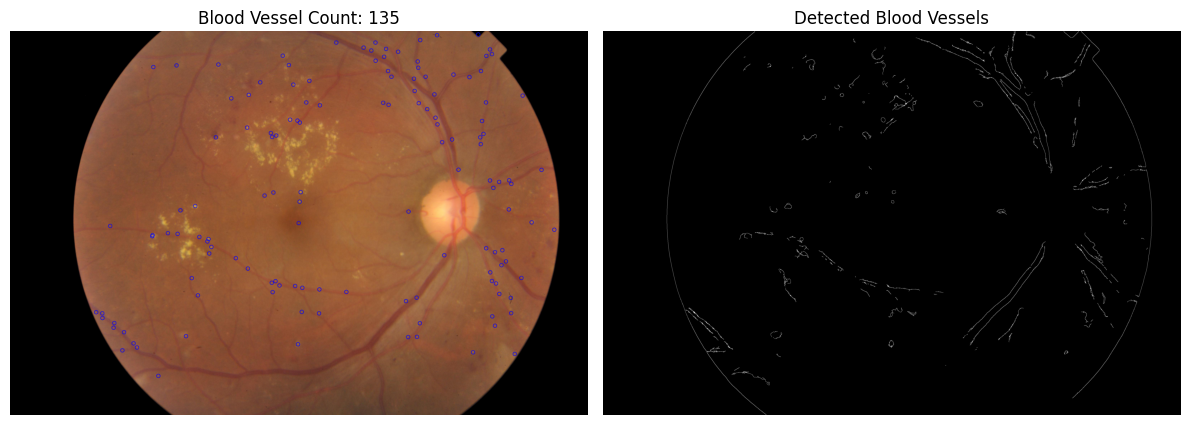

In [21]:
# NEED TO MAKE IGNORE YELLOW SPOTS ND BE MORE SENSITIVE TO SMALLER BLOOD VESSELS

# Blood vessel detection using Canny edge detection and morphological operations
def detect_blood_vessels(equalized_image):
    # Use Canny Edge Detection for blood vessels
    edges = cv2.Canny(equalized_image, threshold1=50, threshold2=150)
    
    # Morphological operations to enhance vessels
    kernel = np.ones((2, 2), np.uint8)
    vessels = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
    return vessels

# Detect blood vessels
vessels = detect_blood_vessels(equalized_image)

# Detect and count blood vessel segments
def count_blood_vessels(vessels):
    # Find connected components of the blood vessels
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(vessels, connectivity=8)
    
    # Filter out small components (noise)
    filtered_labels = [centroid for i, centroid in enumerate(centroids) if stats[i][4] > 50]  # area threshold of 50
    
    return len(filtered_labels), filtered_labels

# Count blood vessels
vessel_count, vessel_centroids = count_blood_vessels(vessels)

# Visualize vessel centroids on the original image
marked_image = original_image.copy()
for centroid in vessel_centroids:
    x, y = int(centroid[0]), int(centroid[1])
    cv2.circle(marked_image, (x, y), 10, (255, 0, 0), 2)  # Blue circle for vessels

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the marked image with the vessel count
axs[0].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
axs[0].set_title(f"Blood Vessel Count: {vessel_count}")
axs[0].axis('off')

# Plot the detected blood vessels
axs[1].imshow(vessels, cmap='gray')
axs[1].set_title("Detected Blood Vessels")
axs[1].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


# Exudate Detection

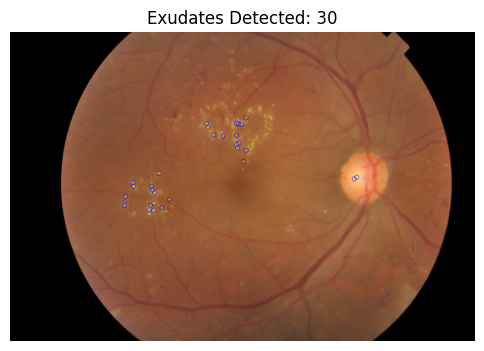

Number of detected exudates: 30


In [17]:
# NEED IT TO PICK UP MORE OF THE YELLOW SPOTS

# Function to detect exudates based on color in the HSV space
def detect_exudates_by_color(original_image):
    # Convert image to HSV
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper bounds for yellow in HSV (exudates are often yellowish)
    lower_yellow = np.array([20, 50, 50])  # Adjust these values as needed
    upper_yellow = np.array([40, 255, 255])
    
    # Create a binary mask where yellow regions are detected
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    
    # Apply morphological operations to remove noise and small false detections
    kernel = np.ones((5, 5), np.uint8)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel)
    
    # Label connected regions (exudates)
    labels = measure.label(yellow_mask, connectivity=2)
    regions = measure.regionprops(labels)
    
    return yellow_mask, labels, regions

# Function to mark detected exudates on the original image
def mark_exudates_on_image(image, exudate_regions):
    marked_image = image.copy()

    # Draw circles around detected exudates
    for region in exudate_regions:
        # Get the centroid of each exudate region
        y, x = region.centroid
        
        # Draw a circle around the centroid on the original image
        cv2.circle(marked_image, (int(x), int(y)), 15, (255, 0, 0), 2)  # Blue circles

    return marked_image

# Load and preprocess the image (assuming it's already preprocessed)
image_with_black_bg, green_channel, equalized_image = load_and_preprocess_image(image_path)

# Detect exudates based on yellow color in the original image
yellow_mask, labels, exudate_regions = detect_exudates_by_color(image_with_black_bg)

# Mark exudates on the original image
marked_image = mark_exudates_on_image(image_with_black_bg, exudate_regions)

# Display the marked image with exudates
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Exudates Detected: {len(exudate_regions)}")
plt.axis('off')
plt.show()

# Print the count of detected exudates
print(f"Number of detected exudates: {len(exudate_regions)}")

# Bifurcation Detection

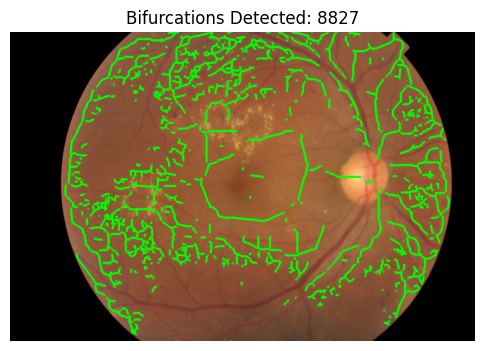

Number of detected bifurcations: 8827


In [18]:
# THIS MIGHT NOT BE FEASIBLE AS WE NEED TO THINK OF A DISTINGUISHABLE FEATURE THAT WE CAN EXPLICITLY LOOK FOR eg. colour

# Function to skeletonize the blood vessel map and find bifurcations
def detect_bifurcations(vessel_image):
    # Skeletonize the vessel image (reduce vessels to 1-pixel width)
    skeleton = skeletonize(vessel_image // 255)
    
    # Find branch points by counting pixels with more than two neighbors
    neighbors = np.zeros(skeleton.shape, dtype=int)
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx != 0 or dy != 0:
                neighbors += np.roll(np.roll(skeleton, dx, axis=0), dy, axis=1)
    
    # Identify bifurcation points (where number of neighbors is greater than 2)
    bifurcations = (neighbors > 2).astype(np.uint8)
    
    # Label bifurcations and count them
    bifurcation_labels = label(bifurcations)
    bifurcation_count = len(np.unique(bifurcation_labels)) - 1  # Subtract 1 for background
    
    return bifurcations, bifurcation_count

# Function to mark detected bifurcations on the original image
def mark_bifurcations_on_image(image, bifurcation_points):
    marked_image = image.copy()
    
    # Find coordinates of bifurcation points
    bifurcation_coords = np.column_stack(np.nonzero(bifurcation_points))
    
    # Draw circles on the original image at bifurcation points
    for y, x in bifurcation_coords:
        cv2.circle(marked_image, (x, y), 5, (0, 255, 0), 2)  # Green circles for bifurcations
    
    return marked_image

# Load and preprocess the image (assuming it's already preprocessed)
image_with_black_bg, green_channel, equalized_image = load_and_preprocess_image(image_path)

# Detect vessels (assuming `vessels` is the binary blood vessel map from earlier)
vessels = (equalized_image > filters.threshold_otsu(equalized_image)).astype(np.uint8) * 255

# Detect bifurcations in the skeletonized vessel image
bifurcations, bifurcation_count = detect_bifurcations(vessels)

# Mark bifurcations on the original image
marked_image = mark_bifurcations_on_image(image_with_black_bg, bifurcations)

# Display the marked image with bifurcations
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Bifurcations Detected: {bifurcation_count}")
plt.axis('off')
plt.show()

# Print the count of detected bifurcations
print(f"Number of detected bifurcations: {bifurcation_count}")

# Large Oedema Detection

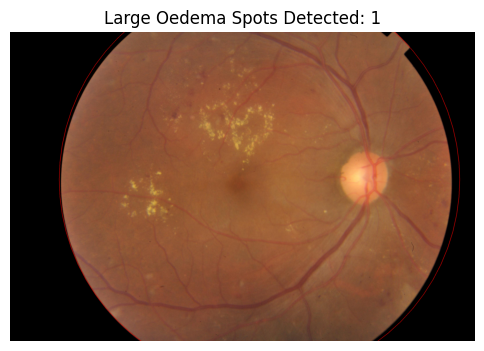

In [19]:
# I THINK THIS IS ABOUT SIZE THRESHOLDS AND COLOUR

# Function to detect large oedema spots
def detect_large_oedema_spots(gray_image, min_area=5000, threshold_factor=1.5):
    # Step 1: Apply Gaussian blur to smooth the image and reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Step 2: Apply a threshold to detect bright regions (objects)
    threshold_value = threshold_factor * cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    binary_objects = blurred_image > threshold_value
    
    # Step 3: Find contours (outlines) of the objects
    contours, _ = cv2.findContours(binary_objects.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 4: Create an empty image for large objects
    large_objects = np.zeros_like(binary_objects, dtype=np.uint8)
    large_object_count = 0
    
    # Step 5: Filter and count objects based on area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            cv2.drawContours(large_objects, [contour], -1, 1, thickness=cv2.FILLED)  # Fill in the large object
            large_object_count += 1
    
    return large_objects, large_object_count, contours

# Function to mark detected large oedema spots on the original image
def mark_large_oedema_on_image(image, contours):
    marked_image = image.copy()
    
    # Draw circles around the large oedema spots
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= 1000:  # Filtering based on the minimum area
            # Get the center and radius of the minimum enclosing circle
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            # Draw the circle on the original image
            cv2.circle(marked_image, center, radius, (0, 0, 255), 2)  # Red circles for oedema spots
    
    return marked_image

# Load and preprocess the image (assuming it's already preprocessed)
image_with_black_bg, green_channel, equalized_image = load_and_preprocess_image(image_path)

# Detect large oedema spots in the green channel
large_oedema_spots, oedema_count, contours = detect_large_oedema_spots(green_channel)

# Mark oedema spots on the original image
marked_image = mark_large_oedema_on_image(image_with_black_bg, contours)

# Display the marked image with large oedema spots
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Large Oedema Spots Detected: {oedema_count}")
plt.axis('off')
plt.show()


# Red Spots (Small Heamatomas) Detection

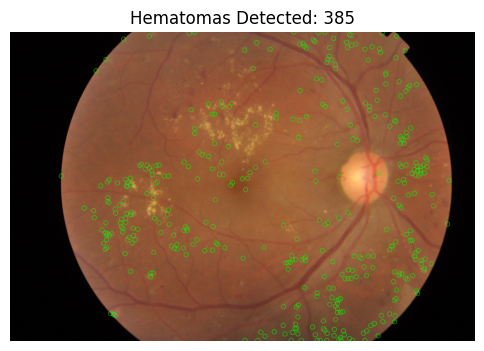

Number of detected hematomas: 385


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import os

# Function to detect hematomas based on color in the HSV space
def detect_hematomas_by_color(original_image):
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper bounds for red in HSV (hematomas)
    lower_red1 = np.array([0, 50, 50])  # Adjusted lower bound for red hue (more specific)
    upper_red1 = np.array([10, 255, 255])  # Upper bound for lower red hue
    lower_red2 = np.array([170, 50, 50])  # Adjusted lower bound for upper red hue
    upper_red2 = np.array([180, 255, 255])  # Upper bound for upper red hue
    
    # Create binary masks for red regions
    red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    # Apply morphological operations to remove small noise
    kernel = np.ones((3, 3), np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)  # Opening to remove small artifacts

    # Label connected regions (hematomas)
    labels = measure.label(red_mask, connectivity=2)
    regions = measure.regionprops(labels)

    # Filter regions based on size and circularity
    hematoma_regions = []
    for region in regions:
        if 20 < region.area < 500:  # Adjust the area range based on typical hematoma sizes
            circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
            if 0.7 < circularity < 1.2:  # Circularity close to 1 means the shape is round
                hematoma_regions.append(region)

    return red_mask, hematoma_regions

# Function to mark detected hematomas on the original image
def mark_hematomas_on_image(image, hematoma_regions):
    marked_image = image.copy()

    # Draw circles around detected hematomas
    for region in hematoma_regions:
        y, x = region.centroid
        cv2.circle(marked_image, (int(x), int(y)), 15, (0, 255, 0), 2)  # Green circles

    return marked_image

# Check if the file exists before loading
if os.path.exists(image_path):
    original_image = cv2.imread(image_path)
    if original_image is None:
        print("Error: Unable to read the image file.")
    else:
        # Detect hematomas in the image
        red_mask, hematoma_regions = detect_hematomas_by_color(original_image)

        # Mark hematomas on the original image
        marked_image = mark_hematomas_on_image(original_image, hematoma_regions)

        # Count the number of detected hematomas
        hematoma_count = len(hematoma_regions)

        # Display the marked image with hematomas
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Hematomas Detected: {hematoma_count}")
        plt.axis('off')
        plt.show()

        # Print the count of detected hematomas
        print(f"Number of detected hematomas: {hematoma_count}")
else:
    print(f"Error: The file {image_path} does not exist.")



# Saving Features to Excel/CVS

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import filters, measure, morphology

# Initialize an empty DataFrame to store the feature extraction data
output_data = pd.DataFrame(columns=['Image Name', 'Exudates', 'Oedema', 'Vessel Count', 'Red Images'])

# Function to process the image and extract features
def process_image(image_path):
    image_name = os.path.basename(image_path)  # Extract image name from path
    image = cv2.imread(image_path)  # Read image in color

    # Extract the green channel for vessel detection
    green_channel = image[:, :, 1]  # Using the green channel for analysis

    # Detect features and count them
    vessels = (green_channel > filters.threshold_otsu(green_channel)).astype(np.uint8) * 255
    bifurcation_count = detect_bifurcations(vessels)[1]
    exudate_mask, exudate_count = detect_exudates_by_color(image)
    oedema_count = detect_large_oedema_spots(green_channel)[1]
    vessel_count = count_vessels(green_channel)

    # Append the extracted data to the DataFrame
    output_data.loc[len(output_data)] = [image_name, bifurcation_count, exudate_count, oedema_count, vessel_count]

# Function to save the results to a CSV file
def save_to_csv(output_file):
    output_data.to_csv(output_file, index=False)

# Main processing loop for a single image
if __name__ == "__main__":
    #image_path = 'path/to/your/image.jpg'  # Replace with your image path
    process_image(image_path)

    # Save the results to a CSV or Excel file
    save_to_csv('feature_extraction_results.csv')  # Uncomment this line for CSV output


ModuleNotFoundError: No module named 'openpyxl'